<a href="https://colab.research.google.com/github/SergeyHSE/DesisionTree.github.io/blob/main/DesisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this task, we will work with [data on patients, some of whom have heart disease]
(https://www.kaggle.com/ronitf/heart-disease-uci ).
We need to build a model that classifies patients into patients with this disease and those who do not have it,
and also analyze the results.

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

In [2]:
from google.colab import files
file = files.upload()

Saving heart.csv to heart.csv


In [3]:
data = pd.read_csv('/content/heart.csv', delimiter=',')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1),
                                                    data['target'], test_size=0.25, random_state=13)
X_train.shape, X_test.shape

((227, 13), (76, 13))

Let's train a decision tree from `sklearn` (`sklearn.tree.Decision Tree Classifier`)
with no limit on the maximum depth (`max_depth=None`). As a seed, we will put `random_state=13`.
Next, we will find the proportion of correct answers of the obtained algorithm in the training sample
(** as a percentage **)

In [5]:
from sklearn.metrics import accuracy_score
dt = DecisionTreeClassifier(max_depth=None, random_state=13)
dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
accuracy_score(y_train, y_pred_train)

1.0

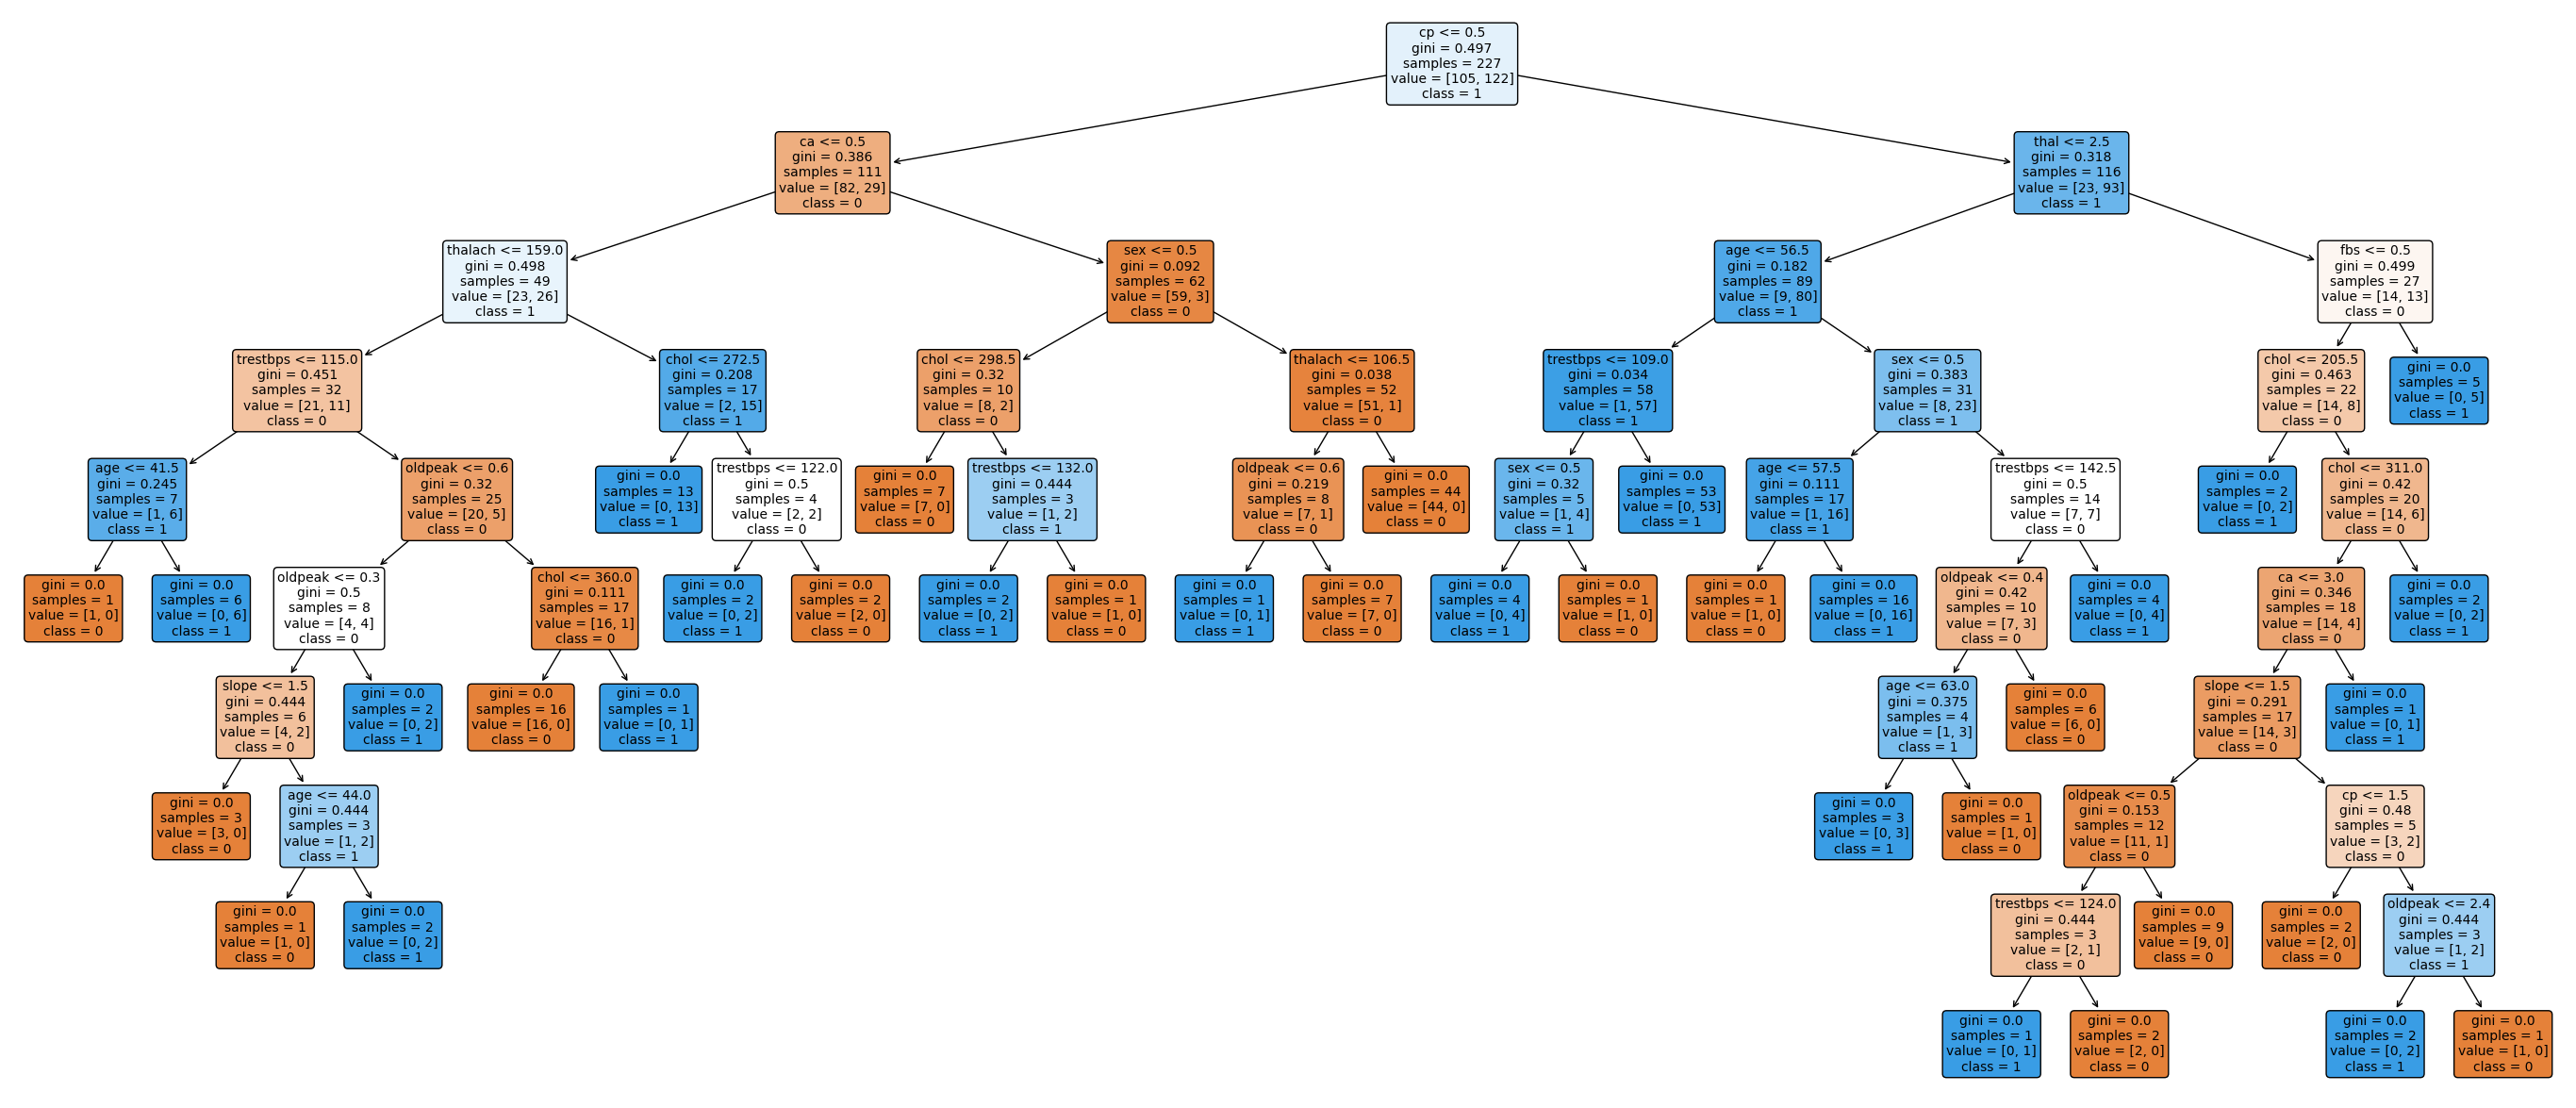

In [6]:
# Build Desision Tree scheme

from sklearn.tree import plot_tree

plt.figure(figsize=(35, 15))
plot_tree(
    dt,
    filled=True,
    rounded=True,
    feature_names=list(X_train.columns),
    class_names=[str(label) for label in dt.classes_],
    fontsize=10,
)
plt.show()

In [7]:
# Find accuracy_score
y_pred_dt = dt.predict(X_test)
accuracy_score(y_test, y_pred_dt)

0.6710526315789473

Using cross-validation, we will select the optimal hyperparameters of the algorithm.
Choose from the following sets:
- `max_depth`: [3, 4, 5, 6, 7, 8, 9, 10, None]
- `max_features`: ['auto', 'log2', None]
- `min_samples_leaf`: range(1, 10)
- `min_samples_split`: range(2, 10)
- `criterion`: ['gini', 'entropy']

In [9]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
grid_searcher = GridSearchCV(DecisionTreeClassifier(random_state=13),
                            param_grid = {'max_depth' : [3, 4, 5, 6, 7, 8, 9, 10, None],
                                          'max_features' : ['auto', 'log2', None],
                                          'min_samples_leaf' : range(1, 10),
                                          'min_samples_split' : range(2, 10),
                                          'criterion' : ['gini', 'entropy']},
                            scoring='accuracy', cv=5, n_jobs=-1)

grid_searcher.fit(X_train, y_train)
grid_searcher.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 9}

In [10]:
#We need find what is the best average value of the proportion of correct answers obtained on cross-validation

grid_searcher.best_score_

0.8323671497584542

In [11]:
#Aply founded parametrs

dt_optimal = DecisionTreeClassifier(criterion='gini', max_depth=9, max_features='log2',
                                    min_samples_leaf=3, min_samples_split=9,
                                    random_state=13)
dt_optimal.fit(X_train, y_train)
y_pred_train_optimal = dt_optimal.predict(X_train)
accuracy_score(y_train, y_pred_train_optimal)

0.9074889867841409

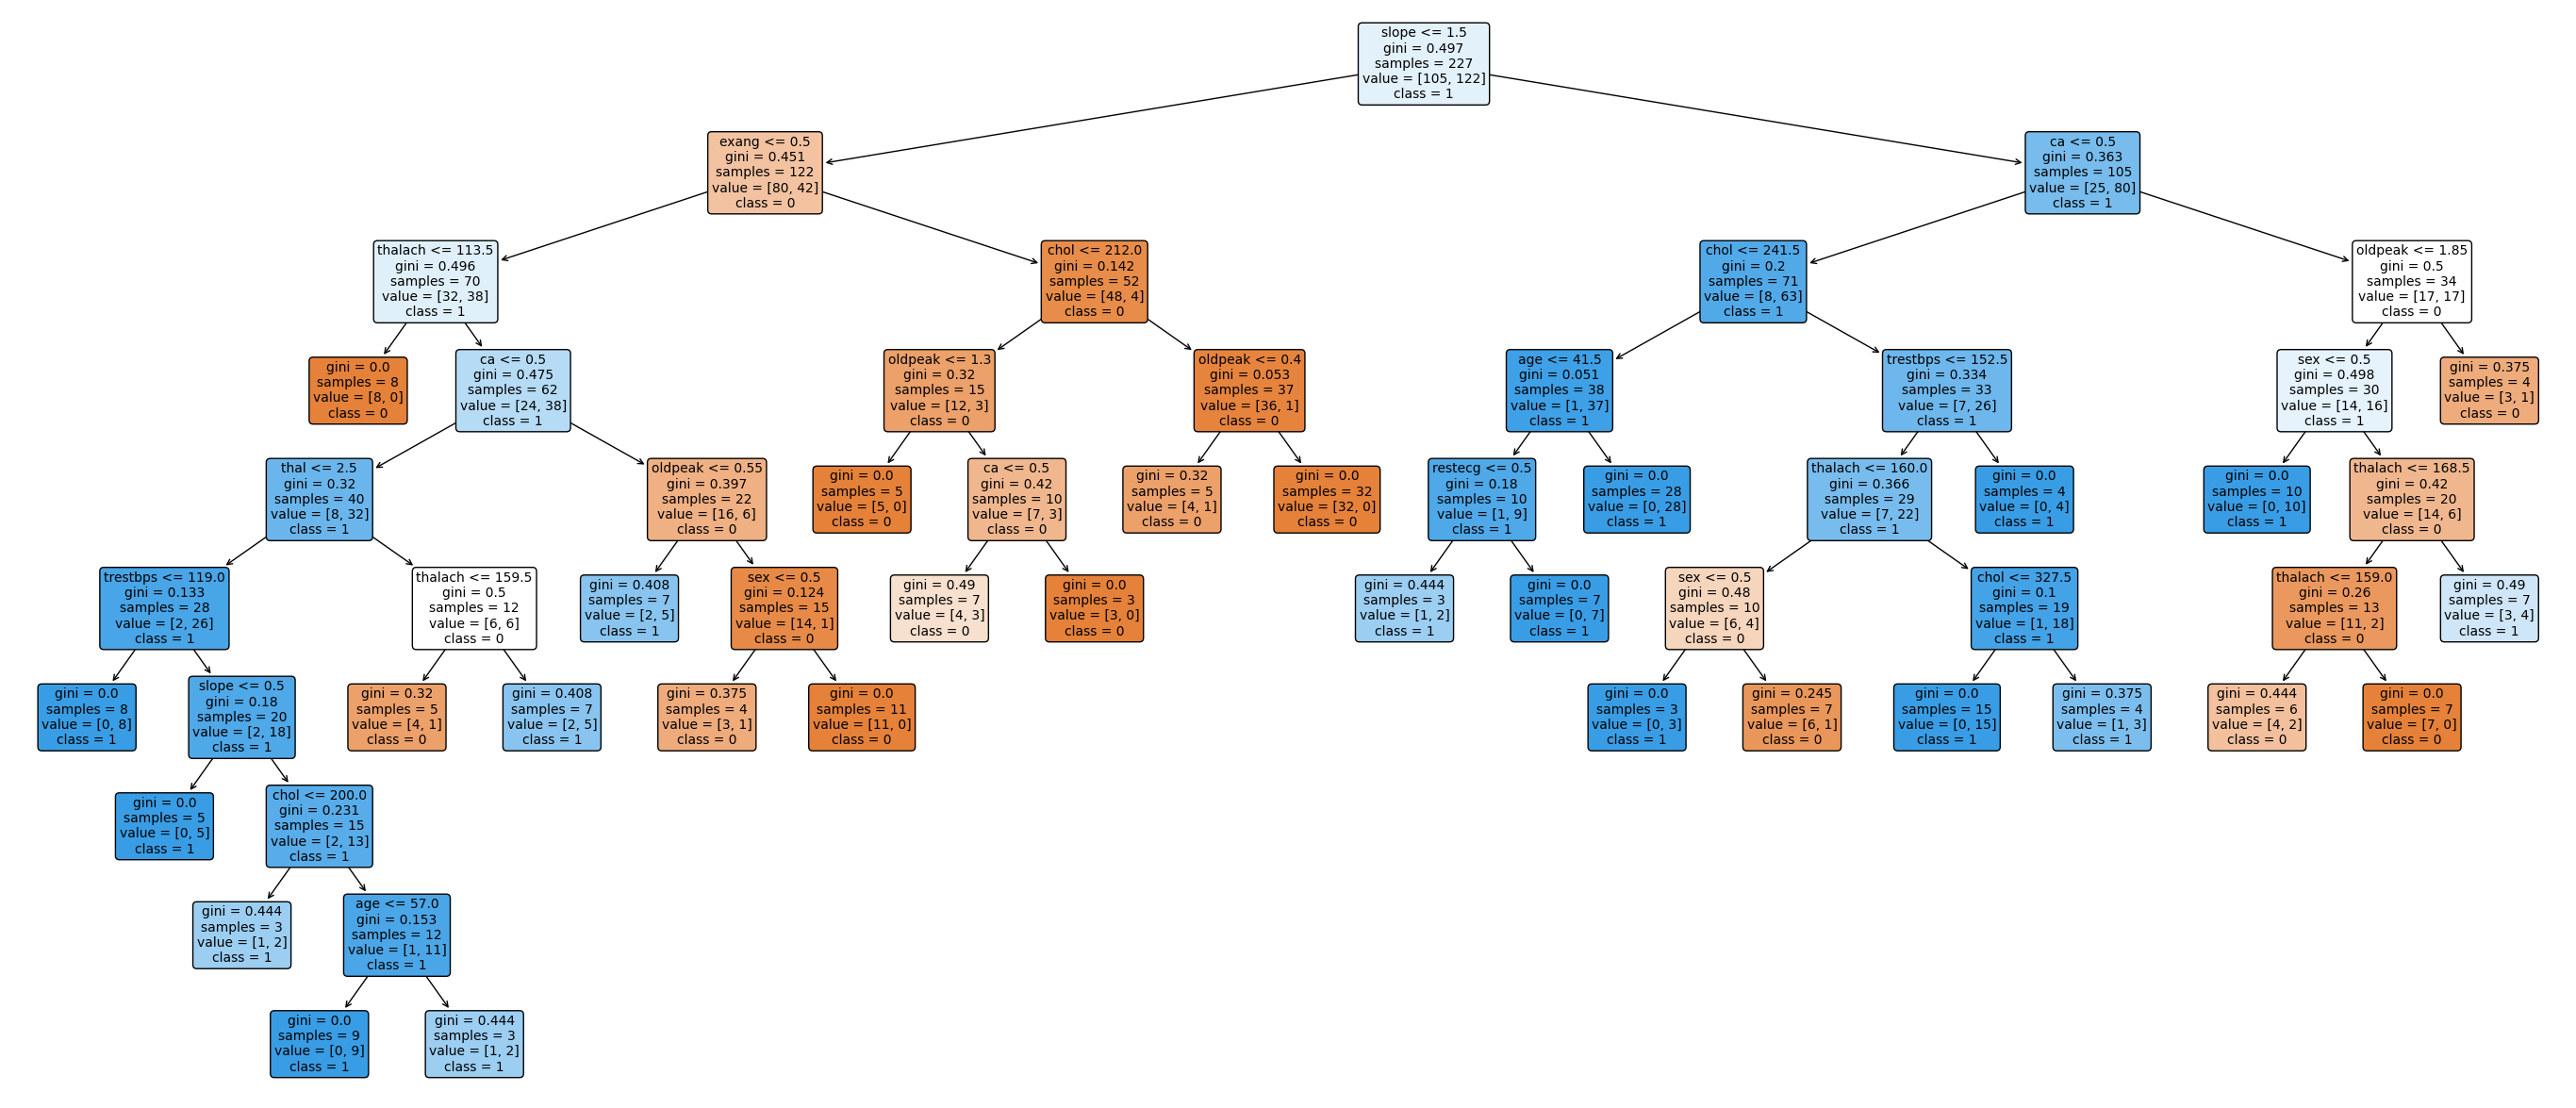

In [12]:
plt.figure(figsize=(35, 15))
plot_tree(
    dt_optimal,
    filled=True,
    rounded=True,
    feature_names=list(X_train.columns),  # Convert to a list
    class_names=[str(label) for label in dt.classes_],
    fontsize=10,
)
plt.show()

In [13]:
# Let's now accuracy score wtith optimal parametrs

y_pred_test_optimal = dt_optimal.predict(X_test)
accuracy_score(y_test, y_pred_test_optimal)

0.7368421052631579

The decision tree allows you to predict not only classes, but also the probabilities of classes
using the 'predict_proba' method.
Let's look at the probabilities of the classes of the resulting decision tree and calculate the AUC-ROC value.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
y_pred_proba = dt_optimal.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_proba)

0.7716701902748413

In [15]:
#We need find which attribute is the most important in the opinion of the resulting decision tree.


dt_optimal.feature_importances_
weights_sorted = sorted(zip(dt_optimal.feature_importances_.ravel(), X_train.columns), reverse=True)
weights = [x[0] for x in weights_sorted]
features = [x[1] for x in weights_sorted]
table = pd.DataFrame({'features' : features, 'weights' : weights})
table

,features,weights
0,slope,0.235356
1,ca,0.184792
2,thalach,0.155527
3,exang,0.153834
4,sex,0.118580
5,oldpeak,0.065503
6,thal,0.036643
7,chol,0.030316
8,age,0.007687
9,trestbps,0.006221


In [16]:
# Define custom dark colors
custom_colors = [
    (0.5, 0.0, 0.0),   # Dark Red
    (0.0, 0.5, 0.0),   # Dark Green
    (0.0, 0.0, 0.5),   # Dark Blue
    (0.5, 0.0, 0.5),   # Dark Purple
    (0.0, 0.5, 0.5),   # Dark Teal
    (0.5, 0.5, 0.0),   # Dark Yellow
    (0.3, 0.3, 0.3),   # Dark Gray
    (0.7, 0.3, 0.3),   # Dark Pink
    (0.3, 0.7, 0.3),   # Dark Lime Green
    (0.3, 0.3, 0.7),   # Dark Indigo
    (0.7, 0.7, 0.0),   # Dark Gold
    (0.0, 0.7, 0.7),   # Dark Cyan
    (0.7, 0.0, 0.7)    # Dark Magenta
    ]

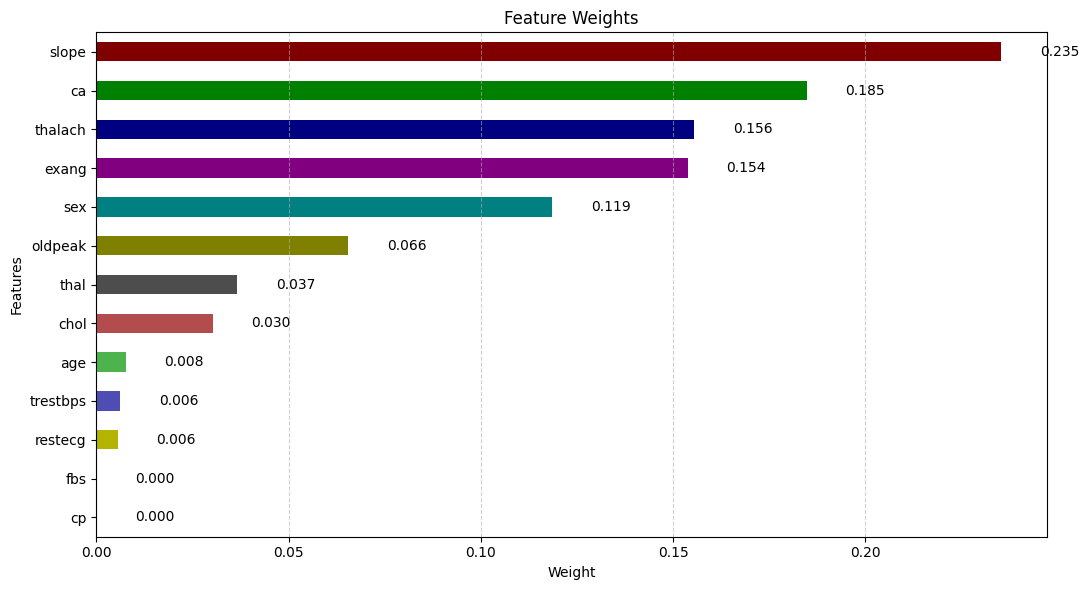

In [17]:
fig, ax = plt.subplots(figsize=(11, 6))
table.plot.barh(x='features', y='weights', color=custom_colors, legend=False, ax=ax)
plt.title('Feature Weights')
plt.xlabel('Weight')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
for i, v in enumerate(table['weights']):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)
plt.tight_layout()
plt.savefig('output.png', dpi=300)
plt.show()